# Version at 1AU and  0.2 Earth Mass
# Deposition version 2 
# To converge, load profiles from GrainGrowth (load_dep=False)

In [1]:
load_dep = False
deposition_version = 2

In [2]:
import numpy as np
import os 
from dedalus import public as de
from dedalus.extras.plot_tools import quad_mesh, pad_limits
import matplotlib.pyplot as plt
from scipy.special import erf 
import logging
logger = logging.getLogger(__name__)

%matplotlib inline

import time

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

from dedalus.extras import plot_tools 

In [3]:
a_1 = 1
AU = 1.496e13
Mp = 0.2 # Earth masses
T_disk = 300 *a_1**(-1/2)

rho_disk = 2.4e-9*a_1**(-11/4)
r_Hill = 2e11*a_1*(Mp)**(1/3)
r_Bondi = 4e10*a_1**(1/2)*Mp

print('disk temperature: ' + str(T_disk))
print('disk density: ' + str(rho_disk))
print('hill radius: {:.4e}'.format(r_Hill))
print('bondi radius: {:.4e}'.format(r_Bondi))

disk temperature: 300.0
disk density: 2.4e-09
hill radius: 1.1696e+11
bondi radius: 8.0000e+09


In [4]:
# Basis and domain

resolution = 256 #500
# normalization factors
r_0 = 1.2e8
T_0 = 1000
P_0 = 1 #1e5 #1
M_0 = 1e-12
m_0 = 1e25
L_0 = 3.144546892817586e+27
Dep_0 = 5.972e27/3.154e7 

# r_outer = 1.496e13/r_0
r_outer = r_Hill /r_0 # 3.4199512e11/r_0
r_inner = 1.2e9/r_0

log_inner = np.log(r_inner) 
log_outer = np.log(r_outer)

log_basis = de.Chebyshev('r', resolution, interval=(log_inner,log_outer))  
domain = de.Domain([log_basis], np.float64)

In [5]:
# Problem

ncc_cutoff = 1e-6 #1e-2
tolerance = 1e-6 #1e-2
# P and T are actually log(P) and log(T)
problem = de.NLBVP(domain,variables = ['lgP', 'lgT', 'lgM', 'lgZgr','m', 'L'], ncc_cutoff = ncc_cutoff)
R = np.log10(np.exp(domain.grid(0))*r_0)

In [6]:
# Parameters

problem.parameters['T_0'] = T_0 
problem.parameters['r_0'] = r_0
problem.parameters['P_0'] = P_0 # unused
problem.parameters['M_0'] = M_0
problem.parameters['m_0'] = m_0
problem.parameters['Dep_0'] = Dep_0
problem.parameters['L_0'] = L_0

lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')
m = domain.new_field(name='m')
L = domain.new_field(name='L')

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0
ones = np.ones(len(r['g']))

pi = np.pi 
Core_mass = Mp*5.972e27
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 0.2*1e-5* 5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*dMtot/(64*np.pi*rcore*sig)
gm = G*Mc 

rhodisk = rho_disk # 7.5e-9 #g/cm**3
Tdisk = T_disk # 370 # kelvin

mdep = rho_o * 4/3 * pi *(1e4)**3
dMdisk = 5e-9 * 5.972e27/3.154e7 


problem.parameters['pi'] = np.pi
problem.parameters['Mc'] = Core_mass 
problem.parameters['mu'] = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
problem.parameters['kb'] = 1.38064852e-16 # g*cm**2/(K*s**2)
problem.parameters['G'] = 6.67408e-8 # cm**3/(g*s**2)
problem.parameters['dMtot'] = 0.2*1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
problem.parameters['sig'] = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
problem.parameters['s0'] = 1e-4 # cm
problem.parameters['rho_o'] = 3 #g cm^-3 grain internal density
problem.parameters['mdep'] = problem.parameters['rho_o']*4/3*np.pi*(1e-4)**(3)
problem.parameters['sigma_b'] = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
problem.parameters['grad_rad_cst'] = - 3*problem.parameters['dMtot']/(64*np.pi*rcore*problem.parameters['sig'])


# problem.parameters['rhodisk'] = 4e-9 # 1e-11 #g/cm**3
# problem.parameters['Tdisk'] = 370 # 150 # kelvin

problem.parameters['rhodisk'] = rhodisk #g/cm**3
problem.parameters['Tdisk'] = Tdisk # kelvin

problem.substitutions['s'] = '(exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)' # radius
s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)


# Deposition Type (3 versions) 

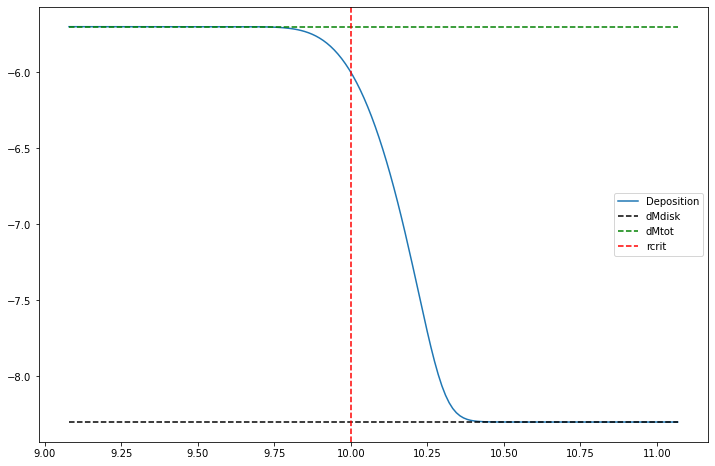

In [7]:
# # Mass deposition 


if deposition_version == 0:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.loadtxt('M1dep.txt')

    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    Mdep_fixed = lgdM['g']
    dlgdM_fixed = dlgdM['g']
    n_roll = Mdep_fixed.shape[0]//4
    Mdep_fixed_rolled =np.roll(Mdep_fixed, n_roll)
    dlgdM_fixed_rolled = np.roll(dlgdM_fixed, n_roll)

    # Correct leftmost values too low from wrapping around
    Mdep_fixed_rolled[:n_roll] = Mdep_fixed[0]
    dlgdM_fixed_rolled[:n_roll] = 0. # Zero gradient for constant value correction

    ones = lgdM['g']/lgdM['g']

    constant = np.log(ones*1e-5)
    dconstant = 0.*ones

    lgdM['g'] = Mdep_fixed_rolled
    dlgdM['g'] = dlgdM_fixed_rolled

    

elif deposition_version == 1:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log(np.loadtxt('Deposition.txt')/Dep_0)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

else:
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log((dMdisk + (dMtot-dMdisk)*((-erf(smooth*X) + 1)/2))/Dep_0)    
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    
problem.parameters['lgDep'] = lgdM
problem.parameters['dlgDep'] = dlgdM

lgDep = domain.new_field(name='lgDep')
dlgDep = domain.new_field(name='dlgDep')
lgDep['g'] = lgdM['g']
dlgDep['g'] = dlgdM['g']

plt.figure(figsize=(12,8))
plt.plot(R, np.log10(np.exp(lgdM['g'])), label='Deposition')
plt.plot(R, np.log10(ones*dMdisk/Dep_0), 'k--', label='dMdisk')
plt.plot(R, np.log10(ones*dMtot/Dep_0), 'g--', label='dMtot')
if deposition_version != 1 and deposition_version !=0:
    plt.axvline(location, color = 'r', ls='--', label='rcrit')
plt.legend()
# plt.plot(R, np.log10(np.exp(dlgdM['g'])))

In [8]:
# Opacity

problem.substitutions['x'] = '2*pi*s*0.3/0.2898'
x = 2*pi*s*0.3/0.2898

# min(2,ex*T*T_0) 
k0 = -10. # -30.
problem.parameters['k0'] = k0

problem.substitutions['Qe'] = "(0.5*(2**k0 + (x*exp(lgT)*T_0)**k0))**(1/k0)"
Qe = (0.5*(2**k0 + (x*np.exp(lgT)*T_0)**k0))**(1/k0)

problem.substitutions['Qk_geo'] = "Qe*3/4*exp(lgZgr)/(s*rho_o)" 
Qk_geo = Qe*3/4*np.exp(lgZgr)/(s*rho_o)

k_gas_cst = 1e-8*(problem.parameters["mu"]/problem.parameters['kb'])**(2/3) # O(10^-14)
problem.parameters['k_gas_cst'] = k_gas_cst

problem.substitutions['k_gas'] = "k_gas_cst*(exp(lgT)*T_0)**(7/3)*(exp(lgP)*P_0)**(2/3)" 
k_gas = k_gas_cst*(np.exp(lgT)*T_0)**(7/3)*(np.exp(lgP)*P_0)**(2/3)

problem.substitutions['kappa'] = "k_gas + Qk_geo"
kappa = k_gas + Qk_geo 

In [9]:
# Gradient  


# problem.substitutions['grad_rad'] = "grad_rad_cst*kappa*exp(lgP)*P_0/(exp(lgT)*T_0)**4"

grad_ad = 0.28
problem.parameters['grad_ad'] = grad_ad


# problem.substitutions['grad_rad'] = '-3*kappa*exp(L)*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
problem.substitutions['grad_rad'] = '-3*kappa*L*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
grad_rad = -3*kappa*L*L_0/(64*pi*sigma_b*gm) * np.exp(lgP)*P_0/(np.exp(lgT)*T_0)**4


# min
k1 = -10. # -30.
problem.parameters['k1'] = k1
problem.substitutions['grad'] = "(0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)" 
grad = (0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)

In [10]:
# Tstop: v_set = gm/r^2 * Tstop 

gm = problem.parameters['Mc']*problem.parameters['G']
problem.parameters['gm'] = gm

problem.substitutions['rho_g'] = '(exp(lgP)*P_0*mu)/(kb*exp(lgT)*T_0)'
rho_g = (np.exp(lgP)*P_0*mu)/(kb*np.exp(lgT)*T_0)

problem.substitutions['cg'] = 'sqrt(kb*exp(lgT)*T_0/mu)'
cg = np.sqrt(kb*np.exp(lgT)*T_0/mu)

problem.substitutions['Lg'] = '1e-9/rho_g'
Lg = 1e-9/rho_g

l = 30 #1 #15
problem.parameters['l'] = l

problem.substitutions['max'] = "(0.5*(1 + (s/Lg)**l))**(1/l)"
Max = (0.5*(1 + (s/Lg)**l))**(1/l)


problem.substitutions['Tstop'] = '(max*4*rho_o*s)/(9*cg*rho_g)'
Tstop = (Max*4*rho_o*s)/(9*cg*rho_g)

problem.substitutions['v_set'] = 'gm*Tstop/(exp(r)*r_0)**2'
v_set = gm*Tstop/(np.exp(r)*r_0)**2

In [11]:
# Tgrow 

problem.substitutions['v_bm'] = 'sqrt(16*kb*exp(lgT)*T_0/(pi*exp(lgM)*M_0))'
v_bm = np.sqrt(16*kb*np.exp(lgT)*T_0/(np.pi*np.exp(lgM)*M_0))

problem.substitutions['v_dd'] = '0.1*v_set'
v_dd = 0.1*v_set

problem.substitutions['Tgrow_inv'] = '3*exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)'
Tgrow_inv = 3*np.exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)

In [12]:
# Energy equation

# problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**2) * dlgDep * 1e5'
problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**3) * dlgDep * Dep_0 * exp(lgDep)'
drho_dep = -1/(4*pi*(np.exp(r)*r_0)**3) * dlgDep * Dep_0 * np.exp(lgDep)

Trelax = 1e30
problem.parameters['Trelax'] = Trelax

Lcore = problem.parameters['gm']*problem.parameters['dMtot']/(r_inner*r_0)
problem.parameters['Lcore'] = Lcore
print(problem.parameters['Lcore'])

2.515637514254069e+25


In [13]:
# New equations

problem.add_equation('lgZgr = log(exp(lgDep)*Dep_0/(4*pi*gm*Tstop*rho_g))')
# problem.add_equation('lgZgr = log(dMdep/(4*pi*gm*Tstop*rho_g))')
problem.add_equation('dr(lgM) = -Tgrow_inv*(exp(r)*r_0)**3/(gm*Tstop) + dlgDep*(mdep-exp(lgM)*M_0)/(exp(lgM)*M_0)')

In [14]:
# Normalized equations

# problem.parameters['eq1cst'] = -1*problem.parameters['G']*problem.parameters['Mc']*problem.parameters['mu']/(T_0*r_0*problem.parameters['kb'])
problem.add_equation('dr(m) = 4*pi*(exp(r)*r_0)**3 * rho_g/m_0')
problem.add_equation('exp(r) * dr(lgP) = -G*(Mc+m*m_0)*mu/(T_0*r_0*kb*exp(lgT))')
problem.add_equation('dr(lgT) = dr(lgP)*grad')

# problem.add_equation('dr(L) = 4*pi*(exp(r)*r_0)* (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0))')
# problem.add_equation('dr(L)*L_0 = 4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax )')
problem.add_equation('dr(L)*L_0 = (4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax ))')


In [15]:
# Boundary Equations


problem.add_bc("right(lgT) = log(Tdisk/T_0)") # disk temp in kelvins
problem.add_bc("right(lgP) = log(rhodisk*kb*Tdisk/mu/P_0)") # gas law
problem.add_bc("right(lgZgr) = log(1e-3)")
problem.add_bc("left(m) = 0")
problem.add_bc("left(L) = Lcore/L_0")

In [16]:
# solver = problem.build_solver(de.timesteppers.RK443)
solver = problem.build_solver()

2020-09-14 00:51:59,327 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s


Text(0.5, 1.0, 'm')

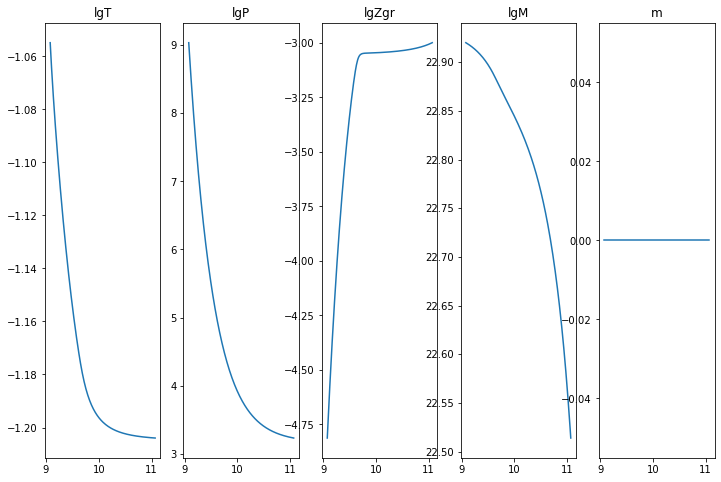

In [17]:
# initial conditions and referencing local grid state fields

lgr = domain.grid(0)
Rscale = np.log10(np.exp(domain.grid(0))*r_0)
lgT1 = solver.state['lgT']
lgP1 = solver.state['lgP']
lgZgr1 = solver.state['lgZgr']
lgM1 = solver.state['lgM']

L1 = solver.state['L']
m1= solver.state['m']

# Load from constant Mass and Zgr version

lgP_initial = np.loadtxt("Pressure.txt")
lgT_initial = np.loadtxt("Temperature.txt")
Zi = np.loadtxt('Zgr.txt')
Mi = np.loadtxt('M.txt')

lgP1['g'] = lgP_initial
lgT1['g'] = lgT_initial
ones = lgT1['g']/lgT1['g']

L1['g'] = ones*problem.parameters['Lcore']/L_0

lgZgr1['g'] = Zi 

lgM1['g'] = Mi
m1['g'] = ones*0


if load_dep: 
    lgP1['g'] = np.loadtxt("Pressure_dep.txt")
    lgT1['g'] = np.loadtxt("Temperature_dep.txt")
    L1['g'] = np.loadtxt('L_dep.txt')
    lgZgr1['g'] = np.loadtxt('Zgr_dep.txt') 
    lgM1['g'] = np.loadtxt('M_dep.txt')
    m1['g'] = np.loadtxt('m_dep.txt')
    
    
plt.figure(figsize=(12,8))
plt.subplot(1,5,1)
plt.plot(Rscale,lgT1['g'])
plt.title("lgT")
plt.subplot(1,5,2)
plt.plot(Rscale, lgP1['g'])
plt.title("lgP")
plt.subplot(1,5,3)
plt.plot(Rscale, np.log10(np.exp(lgZgr1['g'])))
plt.title("lgZgr")
plt.subplot(1,5,4)
plt.plot(Rscale, lgM1['g'])
plt.title("lgM")
plt.subplot(1,5,5)
plt.plot(Rscale, m1['g'])
plt.title("m")

In [18]:

lgT_list = [np.copy(lgT1['g'])]
lgP_list = [np.copy(lgP1['g'])]
lgZgr_list = [np.copy(lgZgr1['g'])]
lgM_list = [np.copy(lgM1['g'])]
m_list = [np.copy(m1['g'])]
L_list = [np.copy(L1['g'])]

2020-09-14 00:52:03,251 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-09-14 00:52:03,992 __main__ 0/1 INFO :: Perturbation norm: 28.765538406039244
2020-09-14 00:52:03,993 __main__ 0/1 INFO :: lgT iterate: -0.8786631949247283
2020-09-14 00:52:03,994 __main__ 0/1 INFO :: lgP iterate: 8.575280773333295
2020-09-14 00:52:03,995 __main__ 0/1 INFO :: lgM iterate: 17.795176757935238
2020-09-14 00:52:03,996 __main__ 0/1 INFO :: lgZgr iterate: -0.9959795592474299
2020-09-14 00:52:03,997 __main__ 0/1 INFO :: m iterate: 2.335274296161316e-08
2020-09-14 00:52:03,998 __main__ 0/1 INFO :: L iterate: 0.00800000000000129


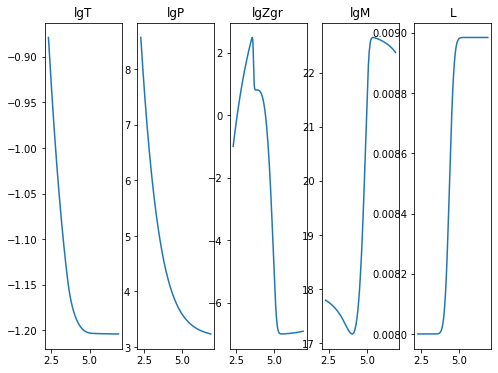

2020-09-14 00:52:09,743 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-09-14 00:52:11,263 __main__ 0/1 INFO :: Perturbation norm: 11.052147946826949
2020-09-14 00:52:11,266 __main__ 0/1 INFO :: lgT iterate: -0.2787701848069215
2020-09-14 00:52:11,267 __main__ 0/1 INFO :: lgP iterate: 6.7229406745296005
2020-09-14 00:52:11,267 __main__ 0/1 INFO :: lgM iterate: 19.094817713198847
2020-09-14 00:52:11,270 __main__ 0/1 INFO :: lgZgr iterate: 0.8897769757404936
2020-09-14 00:52:11,277 __main__ 0/1 INFO :: m iterate: -4.8120094686687764e-08
2020-09-14 00:52:11,278 __main__ 0/1 INFO :: L iterate: 0.007999999999999586


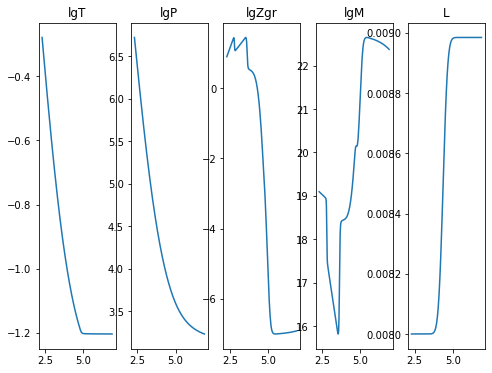

2020-09-14 00:52:15,449 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-09-14 00:52:16,920 __main__ 0/1 INFO :: Perturbation norm: 6.023193760375604
2020-09-14 00:52:16,921 __main__ 0/1 INFO :: lgT iterate: -0.19534678469945876
2020-09-14 00:52:16,923 __main__ 0/1 INFO :: lgP iterate: 7.002261153728659
2020-09-14 00:52:16,924 __main__ 0/1 INFO :: lgM iterate: 20.56365272715915
2020-09-14 00:52:16,925 __main__ 0/1 INFO :: lgZgr iterate: 0.19149822188516685
2020-09-14 00:52:16,926 __main__ 0/1 INFO :: m iterate: 2.5051994922975496e-09
2020-09-14 00:52:16,927 __main__ 0/1 INFO :: L iterate: 0.007999999999999563


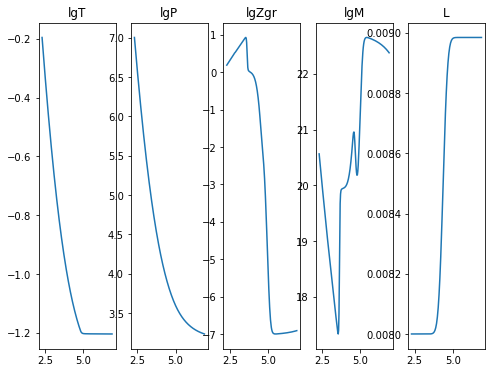

2020-09-14 00:52:21,881 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2020-09-14 00:52:24,303 __main__ 0/1 INFO :: Perturbation norm: 4.93568986292392
2020-09-14 00:52:24,304 __main__ 0/1 INFO :: lgT iterate: -0.19481864534389848
2020-09-14 00:52:24,305 __main__ 0/1 INFO :: lgP iterate: 7.0040265387252925
2020-09-14 00:52:24,306 __main__ 0/1 INFO :: lgM iterate: 21.126116143165525
2020-09-14 00:52:24,307 __main__ 0/1 INFO :: lgZgr iterate: -0.6195817639504084
2020-09-14 00:52:24,308 __main__ 0/1 INFO :: m iterate: 3.3163710666528345e-09
2020-09-14 00:52:24,309 __main__ 0/1 INFO :: L iterate: 0.008000000000000148


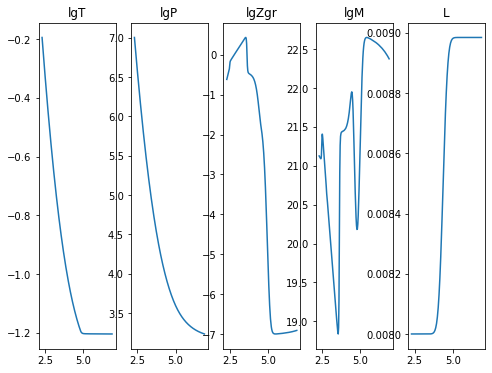

2020-09-14 00:52:30,186 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s
2020-09-14 00:52:32,338 __main__ 0/1 INFO :: Perturbation norm: 5.086890774333036
2020-09-14 00:52:32,349 __main__ 0/1 INFO :: lgT iterate: -0.19481933444674604
2020-09-14 00:52:32,350 __main__ 0/1 INFO :: lgP iterate: 7.00403021254769
2020-09-14 00:52:32,351 __main__ 0/1 INFO :: lgM iterate: 22.11902941925651
2020-09-14 00:52:32,352 __main__ 0/1 INFO :: lgZgr iterate: -1.2815296982627884
2020-09-14 00:52:32,353 __main__ 0/1 INFO :: m iterate: 3.313117669101473e-09
2020-09-14 00:52:32,354 __main__ 0/1 INFO :: L iterate: 0.00800000000000036


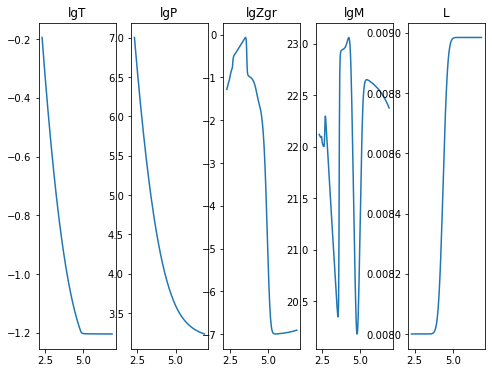

2020-09-14 00:52:37,368 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-09-14 00:52:38,398 __main__ 0/1 INFO :: Perturbation norm: 5.463000150531928
2020-09-14 00:52:38,406 __main__ 0/1 INFO :: lgT iterate: -0.19528937493252962
2020-09-14 00:52:38,407 __main__ 0/1 INFO :: lgP iterate: 7.004162960249616
2020-09-14 00:52:38,408 __main__ 0/1 INFO :: lgM iterate: 23.103140855835512
2020-09-14 00:52:38,409 __main__ 0/1 INFO :: lgZgr iterate: -1.9384408283160006
2020-09-14 00:52:38,410 __main__ 0/1 INFO :: m iterate: 3.3462171922238326e-09
2020-09-14 00:52:38,411 __main__ 0/1 INFO :: L iterate: 0.007999999999999863


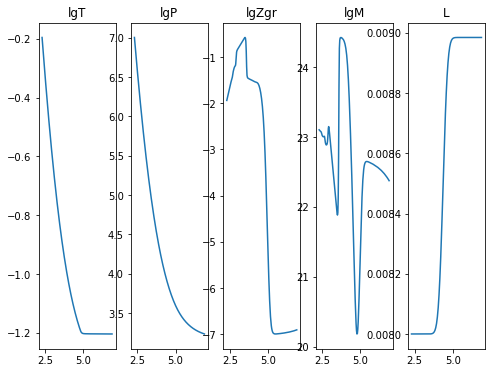

2020-09-14 00:52:42,846 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-09-14 00:52:43,984 __main__ 0/1 INFO :: Perturbation norm: 6.448132420177775
2020-09-14 00:52:43,987 __main__ 0/1 INFO :: lgT iterate: -0.35300581920580676
2020-09-14 00:52:43,990 __main__ 0/1 INFO :: lgP iterate: 7.143921607475637
2020-09-14 00:52:43,992 __main__ 0/1 INFO :: lgM iterate: 24.006809395131555
2020-09-14 00:52:43,995 __main__ 0/1 INFO :: lgZgr iterate: -2.917218194163975
2020-09-14 00:52:43,998 __main__ 0/1 INFO :: m iterate: 9.956369062535941e-11
2020-09-14 00:52:44,000 __main__ 0/1 INFO :: L iterate: 0.007999999999999759


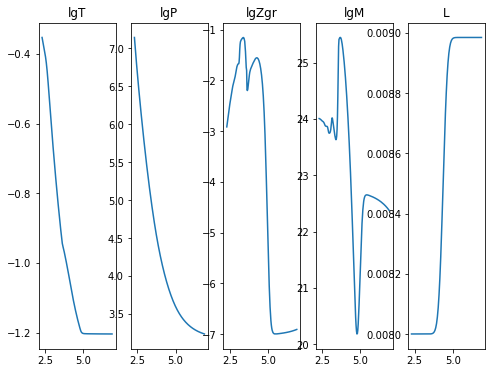

2020-09-14 00:52:48,466 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.3e+00/s
2020-09-14 00:52:49,860 __main__ 0/1 INFO :: Perturbation norm: 6.104168352978588
2020-09-14 00:52:49,869 __main__ 0/1 INFO :: lgT iterate: -0.5554287349042953
2020-09-14 00:52:49,870 __main__ 0/1 INFO :: lgP iterate: 7.454733187575076
2020-09-14 00:52:49,871 __main__ 0/1 INFO :: lgM iterate: 24.83658312053664
2020-09-14 00:52:49,872 __main__ 0/1 INFO :: lgZgr iterate: -4.084848331334519
2020-09-14 00:52:49,874 __main__ 0/1 INFO :: m iterate: 2.3232595625088948e-08
2020-09-14 00:52:49,876 __main__ 0/1 INFO :: L iterate: 0.007999999999999863


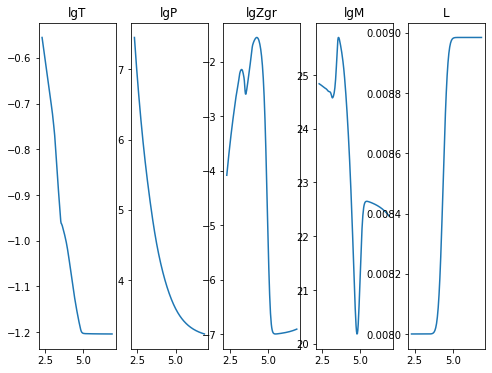

2020-09-14 00:52:55,292 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2020-09-14 00:52:56,663 __main__ 0/1 INFO :: Perturbation norm: 5.341341396344107
2020-09-14 00:52:56,673 __main__ 0/1 INFO :: lgT iterate: -0.7670032883638577
2020-09-14 00:52:56,675 __main__ 0/1 INFO :: lgP iterate: 7.927740359885153
2020-09-14 00:52:56,676 __main__ 0/1 INFO :: lgM iterate: 25.67543259217488
2020-09-14 00:52:56,677 __main__ 0/1 INFO :: lgZgr iterate: -5.434450379330688
2020-09-14 00:52:56,678 __main__ 0/1 INFO :: m iterate: 4.530063213437074e-09
2020-09-14 00:52:56,680 __main__ 0/1 INFO :: L iterate: 0.00799999999999989


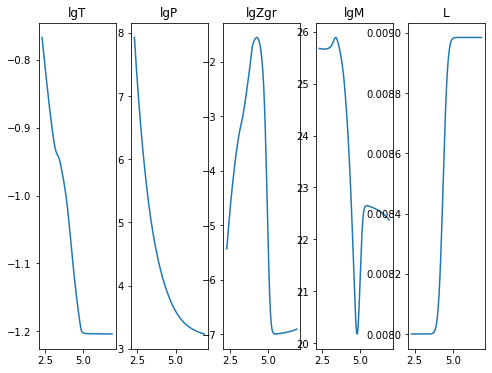

2020-09-14 00:53:00,833 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-09-14 00:53:02,431 __main__ 0/1 INFO :: Perturbation norm: 1.9650673008201358
2020-09-14 00:53:02,432 __main__ 0/1 INFO :: lgT iterate: -0.8267700726926442
2020-09-14 00:53:02,433 __main__ 0/1 INFO :: lgP iterate: 8.026740730602418
2020-09-14 00:53:02,434 __main__ 0/1 INFO :: lgM iterate: 26.31765874197726
2020-09-14 00:53:02,435 __main__ 0/1 INFO :: lgZgr iterate: -6.051251767673325
2020-09-14 00:53:02,436 __main__ 0/1 INFO :: m iterate: 1.831956619735564e-08
2020-09-14 00:53:02,438 __main__ 0/1 INFO :: L iterate: 0.007999999999999775


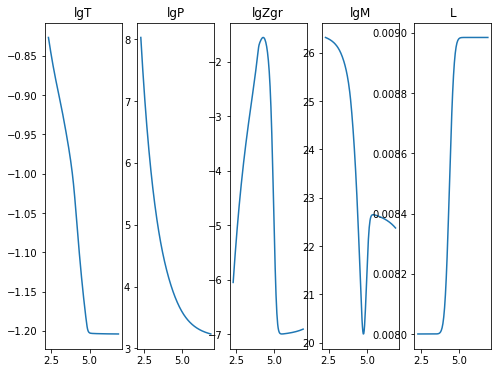

2020-09-14 00:53:06,932 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-09-14 00:53:08,282 __main__ 0/1 INFO :: Perturbation norm: 0.11180586660859605
2020-09-14 00:53:08,283 __main__ 0/1 INFO :: lgT iterate: -0.816095285086047
2020-09-14 00:53:08,284 __main__ 0/1 INFO :: lgP iterate: 8.009667598809816
2020-09-14 00:53:08,284 __main__ 0/1 INFO :: lgM iterate: 26.3775685040718
2020-09-14 00:53:08,285 __main__ 0/1 INFO :: lgZgr iterate: -6.058106211441139
2020-09-14 00:53:08,286 __main__ 0/1 INFO :: m iterate: 1.8087505271324744e-08
2020-09-14 00:53:08,286 __main__ 0/1 INFO :: L iterate: 0.007999999999999802


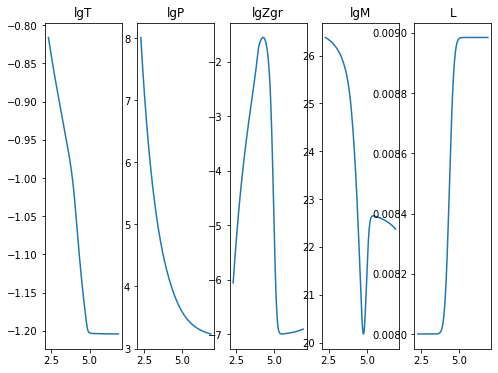

2020-09-14 00:53:12,631 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-09-14 00:53:13,772 __main__ 0/1 INFO :: Perturbation norm: 0.0006245144626825059
2020-09-14 00:53:13,773 __main__ 0/1 INFO :: lgT iterate: -0.8159192989924894
2020-09-14 00:53:13,774 __main__ 0/1 INFO :: lgP iterate: 8.009600963451344
2020-09-14 00:53:13,775 __main__ 0/1 INFO :: lgM iterate: 26.377675211591185
2020-09-14 00:53:13,775 __main__ 0/1 INFO :: lgZgr iterate: -6.057846719502126
2020-09-14 00:53:13,777 __main__ 0/1 INFO :: m iterate: 1.803256055588065e-08
2020-09-14 00:53:13,777 __main__ 0/1 INFO :: L iterate: 0.007999999999999821


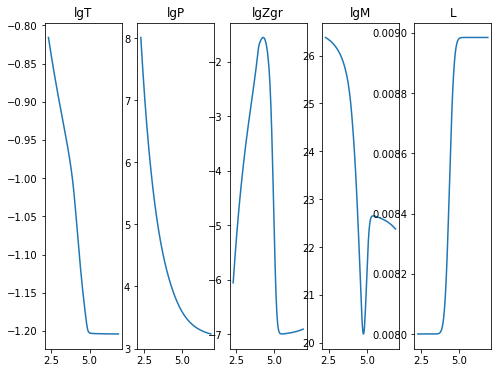

2020-09-14 00:53:17,587 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-09-14 00:53:18,273 __main__ 0/1 INFO :: Perturbation norm: 3.385758343265854e-08
2020-09-14 00:53:18,274 __main__ 0/1 INFO :: lgT iterate: -0.8159192954914987
2020-09-14 00:53:18,275 __main__ 0/1 INFO :: lgP iterate: 8.009600969709766
2020-09-14 00:53:18,276 __main__ 0/1 INFO :: lgM iterate: 26.37767521162513
2020-09-14 00:53:18,279 __main__ 0/1 INFO :: lgZgr iterate: -6.0578467204504385
2020-09-14 00:53:18,280 __main__ 0/1 INFO :: m iterate: 1.8024218118029012e-08
2020-09-14 00:53:18,281 __main__ 0/1 INFO :: L iterate: 0.007999999999999818


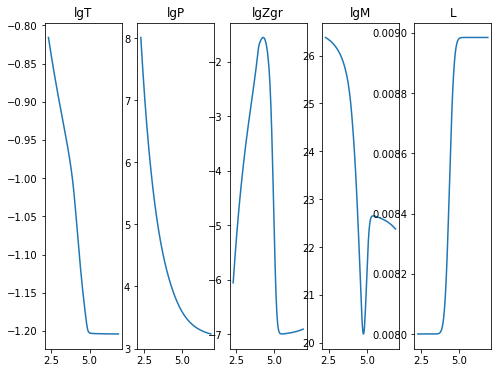

In [19]:
# Iterations

i = 0

pert = solver.perturbations.data
pert.fill(1+tolerance)
start_time = time.time()
while np.sum(np.abs(pert)) > tolerance:
    solver.newton_iteration()
    lgT_list.append(np.copy(lgT1['g'])) # save
    lgP_list.append(np.copy(lgP1['g']))
    lgZgr_list.append(np.copy(lgZgr1['g'])) 
    lgM_list.append(np.copy(lgM1['g'])) 
    L_list.append(np.copy(L1['g']))
    m_list.append(np.copy(m['g']))
    logger.info('Perturbation norm: {}'.format(np.sum(np.abs(pert))))
    logger.info('lgT iterate: {}'.format(lgT1['g'][0]))
    logger.info('lgP iterate: {}'.format(lgP1['g'][0]))
    logger.info('lgM iterate: {}'.format(lgM1['g'][0]))
    logger.info('lgZgr iterate: {}'.format(lgZgr1['g'][0]))
    logger.info('m iterate: {}'.format(m1['g'][0]))
    logger.info('L iterate: {}'.format(L1['g'][0]))
    
    plt.figure(figsize=(8,6))
    plt.subplot(1,5,1)
    plt.plot(domain.grid(0),lgT1['g'])
    plt.title("lgT")
    plt.subplot(1,5,2)
    plt.plot(domain.grid(0), lgP1['g'])
    plt.title("lgP")
    plt.subplot(1,5,3)
    plt.plot(domain.grid(0),lgZgr1['g'])
    plt.title("lgZgr")
    plt.subplot(1,5,4)
    plt.plot(domain.grid(0), lgM1['g'])
    plt.title("lgM")
    plt.subplot(1,5,5)
    plt.plot(domain.grid(0), L1['g'])
    plt.title("L")
    plt.show()
    
end_time = time.time()

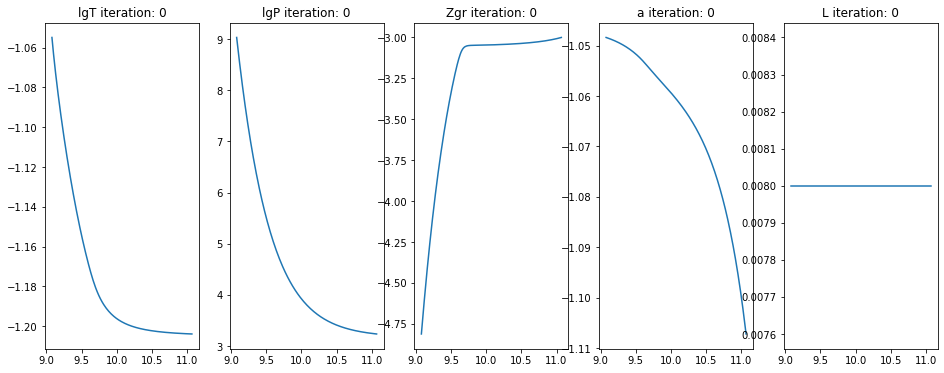

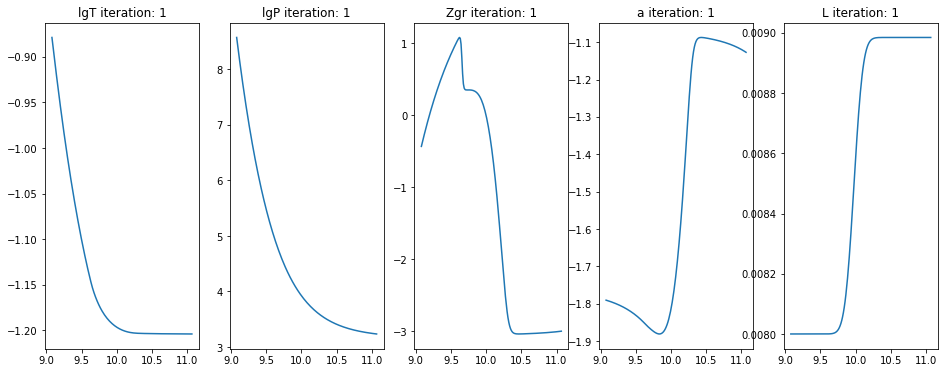

In [ ]:
lower = 0 
if len(lgT_list) > 20:
    lower = len(lgT_list) - 20

R = np.log10(np.exp(domain.grid(0))*r_0)

for i in range(lower,len(lgT_list)):
        plt.figure(figsize=(16,6))
        
        plt.subplot(1,5,1)
        plt.plot(R,lgT_list[i])
        plt.title("lgT iteration: " + str(i))
        
        plt.subplot(1,5,2)
        plt.plot(R, lgP_list[i])
        plt.title("lgP iteration: " + str(i))
        
        plt.subplot(1,5,3)
        plt.plot(R, np.log10(np.exp(lgZgr_list[i])))
        plt.title("Zgr iteration: " + str(i))
        
        # Grain size 
        plt.subplot(1,5,4)
        plt.plot(R, np.log10((np.exp(lgM_list[i])*M_0/(4*np.pi))**(1/3)))
        plt.title("a iteration: " + str(i))
        
#         plt.subplot(1,5,5)
#         plt.plot(R, m_list[i])
#         plt.title("m iteration: " + str(i))

        plt.subplot(1,5,5)
        plt.plot(R, L_list[i])
        plt.title("L iteration: " + str(i))
        
        

In [ ]:
lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]
m['g'] = m_list[-1]
L['g'] = L_list[-1]

In [ ]:
# Grad

Grad = grad.evaluate()
Grad.require_grid_space()
Grad_rad = grad_rad.evaluate()
Grad_rad.require_grid_space()


RCB = 0
epsilon = 0.001
for i in range(0, len(Grad['g'] - 1)):
    if np.abs(Grad['g'][i] - 0.28) < epsilon:
        RCB = i
        break

        
plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
plt.plot(R, grad_ad*np.ones(len(R)))
plt.plot(R[RCB], Grad['g'][RCB], 'ro', label = 'RCB')
plt.plot(R, -Grad_rad['g'])
plt.ylim(0, 0.5)
plt.legend()

plt.title('Grad')

In [ ]:
TStop = Tstop.evaluate()
TStop.require_grid_space()
plt.plot(R, np.log10(TStop['g']))
plt.title('Tstop')

In [ ]:
Tgrow = 1/Tgrow_inv
TGrow = Tgrow.evaluate()
TGrow.require_grid_space()
plt.plot(R, np.log10(TGrow['g']))
plt.title('Tgrow')

# New analysis section (Jan 30)


In [ ]:
Bondi = r_Bondi # cm
# Bondi = 3.7e11 # cm
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']

Tsettl = np.ones(len(R))

for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')


Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))



In [ ]:
Bondi = 3.7e11 # cm
Bondi = 8.9442713e10
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']


Tsettl = np.ones(len(R))


for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')
plt.title('Tsettl')

Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))

In [ ]:
# Ormel profile
size = s.evaluate()
size.require_grid_space()
kappa_gr = Qk_geo.evaluate()
kappa_gr.require_grid_space()


plt.figure(figsize=(12,8))
plt.plot(R, np.exp(lgZgr['g']), 'k-', label='Zgr')
plt.plot(R, kappa_gr['g'], 'm-', label='kappa_gr')
plt.plot(R, size['g'], 'b-', label='s')
plt.yscale('log')
plt.ylim((1e-9, 1e2))
plt.legend()

In [ ]:
rho_gas = rho_g.evaluate()
rho_gas.require_grid_space()

lgt = lgT_list[-1]


plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g'])**(1/3), 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0, 'r-', label='Temperature') 
plt.plot(R, np.exp(lgt)*T_0 *rho_gas['g'] , 'r--', label='Press=Rho*T')
plt.yscale('log')
plt.legend()

In [ ]:
plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g']/rhodisk)**(1/3) , 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0 / Tdisk, 'r-', label='Temperature') 
plt.yscale('log')
plt.legend()

In [ ]:
Env = np.zeros(len(R))

En = 4*np.pi*(np.exp(r)*r_0)**2 *rho_g 

m = En.evaluate()
m.require_grid_space()

for i in range(0, len(R)):
    Env[i] = np.trapz(m['g'][0:i], S[0:i]) 
    
    
plt.plot(R, Env)
env_mass = Env[-1]
print("Envelope mass (g): {:e}".format(env_mass))

In [ ]:
dlgZgr = lgZgr.differentiate('r')
dlgP = lgP.differentiate('r')

# Multiply dlgZgr by Zgr to get dZgr (as a proxy for dmu = d(1+Zgr) = dZgr)
grad_mu= dlgZgr['g']/ dlgP['g'] 
grad_mu *= np.exp(lgZgr['g'])

#grad_mu.evaluate()
#grad_mu.require_grid_space()

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
#plt.plot(R, dlgZgr['g'] / dlgP['g'], label='Grad_mu')
plt.plot(R, grad_mu, label='Grad_mu')
plt.ylim(-0.5, 4)
plt.legend()

In [ ]:
lgMu = np.log(1+np.exp(lgZgr))
dlgMu = log_basis.Differentiate(lgMu)
dlgP = log_basis.Differentiate(np.log(np.exp(lgP) *P_0))

grad_mu = dlgMu/dlgP

# grad_mu1 = np.diff( np.log(1+np.exp(lgZgr['g'])))/ np.diff(np.log(np.exp(lgP['g']) *P_0)) 
Grad_mu = grad_mu.evaluate()
Grad_mu.require_grid_space()

grad_diff = grad_rad - grad_mu - (-grad_ad) 
Grad_diff = grad_diff.evaluate() 
Grad_diff.require_grid_space() 


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
# plt.plot(R, Grad_diff['g'])
# plt.plot(R,Grad_mu['g'])
plt.plot(R, -Grad_rad['g'], label = 'Grad_rad')
plt.plot(R, grad_ad*np.ones(len(R)), label = 'Grad_ad')
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
plt.plot(R, Grad_diff['g'], label = 'Grad difference')
plt.plot(R, np.zeros(len(R)), 'k-') 
plt.legend()
plt.ylim((-4, 4))
plt.subplot(1,2,2)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
# plt.plot(R[1:], grad_mu1)
plt.legend()
plt.ylim((-4, 4))

In [ ]:
# Plot R_0 for fingering convection
R_0 = (Grad['g'] - grad_ad)/Grad_mu['g']

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(R_0), label='log10(R_0)')
plt.plot(R, 0*R , 'k-', label='Zero_line')
#plt.ylim(-1.0, 1000.0)
plt.legend()


In [ ]:
# Profile of nu and Xi for Prandtl number
c_gas=np.sqrt(8.32e7 * np.exp(lgt)*T_0 )
cross_sect_H2=2e-15 #cgs H2 cross section
lambda_mfp= 1./ (cross_sect_H2 * rho_gas['g'] / 2 / 1.67e-24)
nu_visc= lambda_mfp * c_gas

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(lambda_mfp), label='lambda_mfp')
plt.plot(R, np.log10(c_gas), label='c_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()       

In [ ]:
gas_gamma=7./5.
kappa_tot =  kappa.evaluate()
kappa_tot.require_grid_space()
#xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt['g'])*T_0)**4.  / rho_gas['g'] / np.exp(lgP['g']) 
xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt)*T_0)**4.  / rho_gas['g'] / kappa_tot['g']/ np.exp(lgP['g'])

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc), label='nu_visc')
plt.plot(R, np.log10(xi_rad), label='xi_rad')

plt.plot(R, np.log10(kappa_tot['g']), label='kappa_tot')

plt.plot(R, np.log10((np.exp(lgt)*T_0)**4.), label='T^4')
plt.plot(R, np.log10(rho_gas['g']), label='rho_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()

In [ ]:
# Profile of Prandtl number
plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc/xi_rad), label='Prandtl number')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()

In [ ]:
# Optical thickness to 'surface'
tau_opt= 10.**R * rho_gas['g'] *kappa_tot['g'] # Approximation to true integral of rho.dz

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(tau_opt), label='tau_opt')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'] - Grad_mu['g'] - grad_ad, label='Ledoux')
plt.plot(R, 0*R , label='Stability')
plt.ylim(-4, 1)
plt.legend()

In [ ]:


##### Tao

#lgMu = np.log(1+np.exp(lgZgr))
lgMu =np.exp(lgZgr)
dlgMu = log_basis.Differentiate(lgMu)
dlgP = log_basis.Differentiate(np.log(np.exp(lgP) *P_0))

grad_mu = dlgMu/dlgP

# grad_mu1 = np.diff( np.log(1+np.exp(lgZgr['g'])))/ np.diff(np.log(np.exp(lgP['g']) *P_0)) 
Grad_mu = grad_mu.evaluate()
Grad_mu.require_grid_space()

grad_diff = grad_rad - grad_mu - (-grad_ad) 
Grad_diff = grad_diff.evaluate() 
Grad_diff.require_grid_space() 


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
# plt.plot(R, Grad_diff['g'])
# plt.plot(R,Grad_mu['g'])
#plt.plot(R, grad_rad['g'], label = 'Grad_rad')
plt.plot(R, grad_ad*np.ones(len(R)), label = 'Grad_ad')
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
plt.plot(R, Grad_diff['g'], label = 'Grad difference')
plt.plot(R, np.zeros(len(R)), 'k-') 
plt.legend()
plt.ylim((-0.3, 0.4))
plt.subplot(1,2,2)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
# plt.plot(R[1:], grad_mu1)
plt.legend()
plt.ylim((-0.1, 0.1))

In [ ]:
np.savetxt("Pressure_dep.txt", lgP_list[-1])
np.savetxt("Temperature_dep.txt", lgT_list[-1])
np.savetxt("Zgr_dep.txt", lgZgr_list[-1])
np.savetxt("M_dep.txt", lgM_list[-1])
np.savetxt("m_dep.txt",  m_list[-1])
np.savetxt("L_dep.txt", L_list[-1])

In [ ]:
prefix = '1_02_'

np.savetxt('saved/'+prefix+'grad.txt', Grad['g'])
np.savetxt('saved/'+prefix+'grad_rad.txt', -Grad_rad['g'])
np.savetxt('saved/'+prefix+'Tstop.txt', np.log10(TStop['g']))
np.savetxt('saved/'+prefix+'Tgrow.txt', np.log10(TGrow['g']))
np.savetxt('saved/'+prefix+'Tsettl.txt', Tsettl) 
np.savetxt('saved/'+prefix+'Zgr.txt', np.exp(lgZgr['g'])) 
np.savetxt('saved/'+prefix+'kappa_gr.txt', kappa_gr['g']) 
np.savetxt('saved/'+prefix+'size.txt', size['g'])
np.savetxt('saved/'+prefix+'rho_gas_cbrt.txt', (rho_gas['g'])**(1/3))
np.savetxt('saved/'+prefix+'Temperature.txt', np.exp(lgt)*T_0)
np.savetxt('saved/'+prefix+'Press.txt', np.exp(lgt)*T_0 *rho_gas['g'])
np.savetxt('saved/'+prefix+'rho_gas_norm.txt', (rho_gas['g']/rhodisk)**(1/3))
np.savetxt('saved/'+prefix+'Temperature_norm.txt',np.exp(lgt)*T_0 / Tdisk)
np.savetxt('saved/'+prefix+'Env.txt', Env)
np.savetxt('saved/'+prefix+'grad_mu.txt', Grad_mu['g'])
np.savetxt('saved/'+prefix+'grad_ad.txt', grad_ad*np.ones(len(R)))
np.savetxt('saved/'+prefix+'grad_diff.txt',  Grad_diff['g'])
np.savetxt('saved/'+prefix+'log10(R_0).txt',  np.log10(R_0))
np.savetxt('saved/'+prefix+'lambda_mfp.txt',  np.log10(lambda_mfp))
np.savetxt('saved/'+prefix+'c_gas.txt',  np.log10(c_gas))
np.savetxt('saved/'+prefix+'nu_visc.txt',  np.log10(nu_visc))
np.savetxt('saved/'+prefix+'xi_rad.txt',  np.log10(xi_rad))
np.savetxt('saved/'+prefix+'kappa_tot.txt',  np.log10(kappa_tot['g']))
np.savetxt('saved/'+prefix+'Tfourth.txt',  np.log10((np.exp(lgt)*T_0)**4.))
np.savetxt('saved/'+prefix+'rho_gas.txt',  np.log10(rho_gas['g']))
np.savetxt('saved/'+prefix+'Prandtl_number.txt',  np.log10(nu_visc/xi_rad))
np.savetxt('saved/'+prefix+'tau_opt.txt',  np.log10(tau_opt))
np.savetxt('saved/'+prefix+'Ledoux.txt',  Grad['g'] - Grad_mu['g'] - grad_ad)
np.savetxt('saved/'+prefix+'R.txt', R)